# HVAC vs ERCOT 4CP event alignment:
This notebook explores how household cooling aligns with the State of Texas’s critical peak power events.

We will be using one-minute interval data from 50 Texas homes and will determine what percentage of homes 
had air conditioning on during these CP events for each year from 2016-2019.

To prepare the data we selected 50 Texas homes with PV and hvac system. We used 1 minute energy(from electricity.eg_realpower_1min) data for the selected homes for the CP dates mentioned below.

In [1]:
# These are the ERCOT 4CP events (start date/time and end date/time) for 2016 - 2019 acquired from
# http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13037&reportTitle=Planned%20Service%20Four%20Coincident%20Peak%20Calculations&showHTMLView=&mimicKey

event_start_dates = ['2019-06-19 17:00:00-05', '2019-07-30 16:30:00-05', '2019-08-12 17:00:00-05', '2019-09-06 16:45:00-05',
               '2018-06-27 17:00:00-05', '2018-07-19 17:00:00-05', '2018-08-23 16:45:00-05', '2018-09-19 16:30:00-05',
               '2017-06-23 16:45:00-05', '2017-07-28 17:00:00-05', '2017-08-16 17:00:00-05', '2017-09-20 16:45:00-05',
               '2016-06-15 17:00:00-05', '2016-07-14 16:00:00-05', '2016-08-11 16:30:00-05', '2016-09-19 16:15:00-05'
              ]
event_end_dates = ['2019-06-19 17:15:00-05', '2019-07-30 16:45:00-05', '2019-08-12 17:15:00-05', '2019-09-06 17:00:00-05',
               '2018-06-27 17:15:00-05', '2018-07-19 17:15:00-05', '2018-08-23 17:00:00-05', '2018-09-19 16:45:00-05',
               '2017-06-23 17:00:00-05', '2017-07-28 17:15:00-05', '2017-08-16 17:15:00-05', '2017-09-20 17:00:00-05',
               '2016-06-15 17:15:00-05', '2016-07-14 16:15:00-05', '2016-08-11 16:45:00-05', '2016-09-19 16:30:00-05']

In [2]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sqla
import os
from config.read_config import get_database_config
from datetime import datetime as dt
import numpy as np
import sys
%matplotlib inline
sys.executable  # shows you your path to the python you're using

'/opt/conda/bin/python'

In [3]:
#Read pre-processed data 
df3 = pd.read_csv('/shared/hvac-4CP.csv')
homes_list = df3.dataid.unique() 
homes_list

array([ 114,  171,  187,  370,  379,  483,  499,  661,  668,  744,  781,
        974, 1103, 1169, 1354, 1642, 1714, 1718, 2129, 2199, 2233, 2335,
       2361, 2814, 2818, 2945, 2986, 3009, 3039, 3134, 3310, 3456, 3482,
       3506, 3538, 3649, 3829, 3849, 3967, 4373, 4767, 5129, 5218, 5275,
       5357, 5403, 5448, 5450, 5545, 5615])

In [4]:
#replace null with 0's 
df3 = df3.fillna(0)
df3.head(10)

,dataid,localminute,air1,air2,furnace1,furnace2,solar,grid
0,114,2016-06-15 17:00:00,2.155,0.0,0.467,0.0,1.364,1.403
1,114,2016-06-15 17:01:00,2.168,0.0,0.468,0.0,1.355,1.368
2,114,2016-06-15 17:02:00,2.168,0.0,0.468,0.0,1.339,1.384
3,114,2016-06-15 17:03:00,2.166,0.0,0.468,0.0,1.321,1.400
4,114,2016-06-15 17:04:00,2.168,0.0,0.470,0.0,1.315,1.409
5,114,2016-06-15 17:05:00,2.167,0.0,0.470,0.0,1.316,1.407
6,114,2016-06-15 17:06:00,2.155,0.0,0.471,0.0,1.308,1.405
7,114,2016-06-15 17:07:00,2.159,0.0,0.470,0.0,1.306,1.408
8,114,2016-06-15 17:08:00,2.157,0.0,0.468,0.0,1.296,1.415
9,114,2016-06-15 17:09:00,2.170,0.0,0.469,0.0,1.280,1.446


In [5]:
#create new column hvac.(hvac is sum of air compressor and furnace circuits.)
df3['hvac'] = df3['air1'] + df3['air2'] + df3['furnace1'] + df3['furnace2']
df3['localminute'] = pd.to_datetime(df3['localminute'])
df3['localminute'] = df3['localminute'].dt.date
df3.head(10)
#df3['dt'] = df3['localminute'].dt.date
#df3['localminute'] = df3['localminute'].dt.date
df3.head(10)

,dataid,localminute,air1,air2,furnace1,furnace2,solar,grid,hvac
0,114,2016-06-15,2.155,0.0,0.467,0.0,1.364,1.403,2.622
1,114,2016-06-15,2.168,0.0,0.468,0.0,1.355,1.368,2.636
2,114,2016-06-15,2.168,0.0,0.468,0.0,1.339,1.384,2.636
3,114,2016-06-15,2.166,0.0,0.468,0.0,1.321,1.400,2.634
4,114,2016-06-15,2.168,0.0,0.470,0.0,1.315,1.409,2.638
5,114,2016-06-15,2.167,0.0,0.470,0.0,1.316,1.407,2.637
6,114,2016-06-15,2.155,0.0,0.471,0.0,1.308,1.405,2.626
7,114,2016-06-15,2.159,0.0,0.470,0.0,1.306,1.408,2.629
8,114,2016-06-15,2.157,0.0,0.468,0.0,1.296,1.415,2.625
9,114,2016-06-15,2.170,0.0,0.469,0.0,1.280,1.446,2.639


In [6]:
#create new dataframe with columns dataid,hvac and date.
hvac_cp_data = pd.DataFrame(df3, columns = ['dataid','hvac', 'localminute'])
hvac_cp_data.head(10)

,dataid,hvac,localminute
0,114,2.622,2016-06-15
1,114,2.636,2016-06-15
2,114,2.636,2016-06-15
3,114,2.634,2016-06-15
4,114,2.638,2016-06-15
5,114,2.637,2016-06-15
6,114,2.626,2016-06-15
7,114,2.629,2016-06-15
8,114,2.625,2016-06-15
9,114,2.639,2016-06-15


In [7]:
#group data by dataid and date and take average of hvac. 
#This gives us avaerage hvac usage for each home for each CP event day.
hvac_cp_data_grouped = hvac_cp_data.groupby(['localminute','dataid']).mean()
reset_hvac_cp_data_grouped = hvac_cp_data_grouped.reset_index()
reset_hvac_cp_data_grouped.head(10)

,localminute,dataid,hvac
0,2016-06-15,114,2.635687
1,2016-06-15,171,0.000000
2,2016-06-15,187,4.238312
3,2016-06-15,370,1.937625
4,2016-06-15,379,3.601375
5,2016-06-15,483,2.177375
6,2016-06-15,499,0.543813
7,2016-06-15,661,2.964625
8,2016-06-15,668,2.945688
9,2016-06-15,744,3.000063


In [8]:
#filtering data only for those interval when AC is actually cooling..
#We consider AC is ON and cooling only when it's drawing power of atleast 500W. 

hvac_on = reset_hvac_cp_data_grouped[reset_hvac_cp_data_grouped['hvac'] > 0.5]
homes_on = (hvac_on['localminute'].value_counts()/50)*100
homes_on_perc = pd.DataFrame(homes_on.reset_index().values, columns=["Date", "Percentage"])
homes_on_percindex = homes_on_perc.sort_index(axis = 0, ascending=True)
homes_on_percindex

,Date,Percentage
0,2017-08-16,88
1,2017-06-23,88
2,2016-08-11,84
3,2017-07-28,82
4,2018-07-19,82
5,2018-08-23,82
6,2016-07-14,80
7,2016-06-15,80
8,2018-06-27,78
9,2016-09-19,78


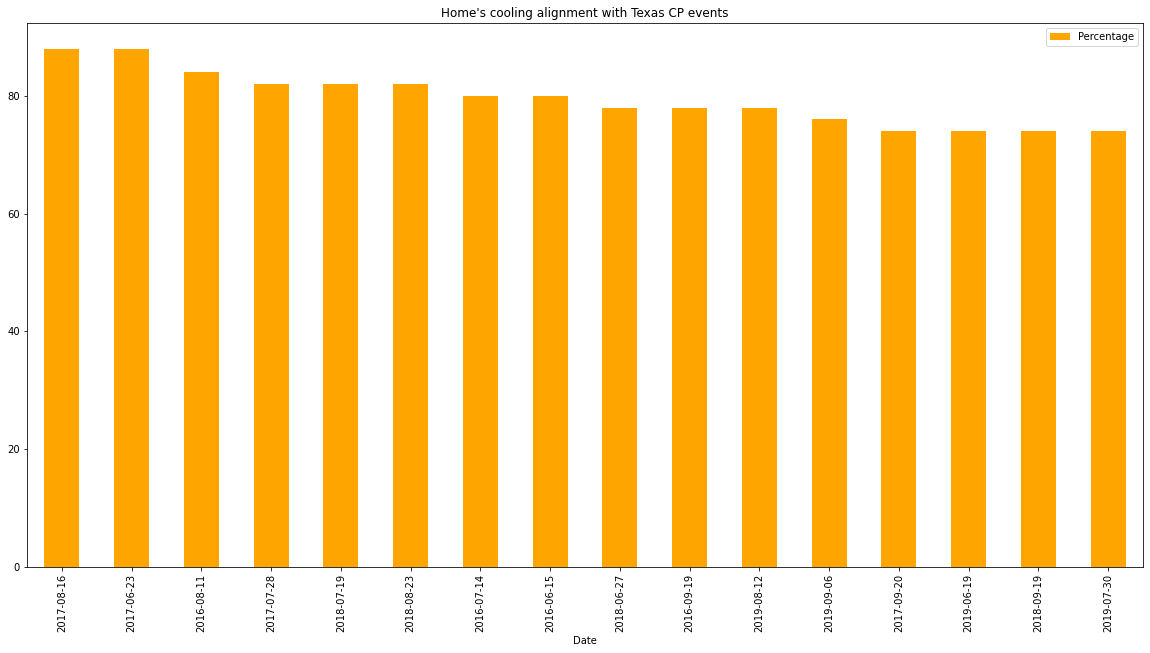

In [9]:
#plot bar chart
homes_on_percindex.plot.bar(x='Date', y='Percentage',figsize=(20,10),color='orange',title="Home's cooling alignment with Texas CP events")
plt.show()

In [10]:
homes_on_percindex['Percentage'].mean()

79.5

## From above results we can see that nearly 80% (79.5%) of homes were ON and cooling for each 4CP event day from 2016-2019.